Imports and loading data from google drive

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Datasets/trip_data/'
df_train = pd.read_csv(path + 'train.csv')
df_target = pd.read_csv(path + 'target.csv')
df_test = pd.read_csv(path + 'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's find out the structure of the train dataset

In [84]:
df_train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2575240,2,2016-04-09 08:41:59,2016-04-09 08:48:11,1,-73.976501,40.788368,-73.957657,40.782452,N,372
1,id3828278,2,2016-04-07 11:12:45,2016-04-07 11:24:24,1,-73.992310,40.769211,-73.990662,40.758137,N,699
2,id1483137,2,2016-04-15 19:53:35,2016-04-15 20:04:49,1,-73.994713,40.746391,-73.969742,40.758484,N,674
3,id0416660,2,2016-04-21 00:47:17,2016-04-21 00:53:41,1,-73.988358,40.718460,-73.951538,40.713840,N,384
4,id2363476,1,2016-01-26 18:34:23,2016-01-26 19:09:14,1,-73.992332,40.743576,-73.979309,40.678200,N,2091


Now let's see some statistics

In [85]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06
mean,1.534915e+00,1.665292e+00,-7.397346e+01,4.075089e+01,-7.397340e+01,4.075182e+01,9.584392e+02
std,4.987797e-01,1.314746e+00,6.231408e-02,3.173031e-02,6.157028e-02,3.645646e-02,5.334345e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073731e+01,-7.399133e+01,4.073591e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075407e+01,-7.397977e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Remove outliers. We will define them as being further than 2*standard_deviation from their mean. (trip_duration column)

In [86]:
mean_duration = np.mean(df_train['trip_duration'])
std_duration = np.std(df_train['trip_duration'])
print('Mean trip duration is ', mean_duration)
print('Trip duration standard deviation is ', std_duration)
print('Train set size before removing duration outliers', len(df_train))
df_train = df_train[np.abs(df_train.trip_duration-mean_duration) <= (2*std_duration)]
print('Train set size after removing duration outliers', len(df_train))


Mean trip duration is  958.4392359340654
Trip duration standard deviation is  5334.34225041338
Train set size before removing duration outliers 1166915
Train set size after removing duration outliers 1165250


Remove data points that are outside New York's limits (-74.03, -73.75) (40.63, 40.85)

In [87]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
df_train = df_train[(df_train.pickup_longitude.between(city_long_border[0], city_long_border[1])) & (df_train.dropoff_longitude.between(city_long_border[0], city_long_border[1])) &
                    (df_train.pickup_latitude.between(city_lat_border[0], city_lat_border[1])) & (df_train.dropoff_latitude.between(city_lat_border[0], city_lat_border[1]))]
print('Train set size after keeping only points inside NY', len(df_train))

Train set size after keeping only points inside NY 1149734


Split datetime columns to 6 different ones: day_period, day_name, month, hour, year, season

In [88]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test['dropoff_datetime'] = pd.to_datetime(df_test.pickup_datetime)

season_dict = {1:'winter', 2:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 7:'summer', 8:'summer', 9:'fall', 10:'fall', 11:'fall'}

def hour_to_period(hour):
  if hour in [22, 23, 0, 1, 2, 3, 4, 5]:
    period = 'late night'
  elif hour in [6, 7, 8, 9, 10, 11]:
    period = 'morning'
  elif hour in [12, 13, 14, 15]:
    period = 'afternoon'
  elif hour in [16, 17, 18, 19, 20, 21]:
    period = 'evening'
  return period

for df in df_train, df_test:
  df['pickup_day_name'] = df['pickup_datetime'].dt.day_name()
  df['pickup_month'] = df['pickup_datetime'].dt.month
  df['pickup_hour'] = df['pickup_datetime'].dt.hour
  df['pickup_year'] = df['pickup_datetime'].dt.year
  df['pickup_season'] = df['pickup_month'].map(season_dict)
  df['pickup_period'] = df['pickup_hour'].map(hour_to_period)

  df['dropoff_day_name'] = df['dropoff_datetime'].dt.day_name()
  df['dropoff_month'] = df['dropoff_datetime'].dt.month
  df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
  df['dropoff_year'] = df['dropoff_datetime'].dt.year
  df['dropoff_season'] = df['dropoff_month'].map(season_dict)
  df['dropoff_period'] = df['dropoff_hour'].map(hour_to_period)

df_train.head


<bound method NDFrame.head of                 id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2575240          2 2016-04-09 08:41:59 2016-04-09 08:48:11   
1        id3828278          2 2016-04-07 11:12:45 2016-04-07 11:24:24   
2        id1483137          2 2016-04-15 19:53:35 2016-04-15 20:04:49   
3        id0416660          2 2016-04-21 00:47:17 2016-04-21 00:53:41   
4        id2363476          1 2016-01-26 18:34:23 2016-01-26 19:09:14   
...            ...        ...                 ...                 ...   
1166910  id1738756          2 2016-03-27 10:45:13 2016-03-27 10:53:33   
1166911  id3231673          1 2016-03-24 23:49:58 2016-03-25 00:06:52   
1166912  id0863928          1 2016-06-24 21:55:33 2016-06-24 22:01:47   
1166913  id1088182          1 2016-01-15 11:56:08 2016-01-15 12:05:33   
1166914  id2591162          2 2016-01-11 08:09:13 2016-01-11 08:15:50   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1      

Create histograms from pickup/dropoff days, and trips per day_period/month. We should reorder so results are easier to interprete

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


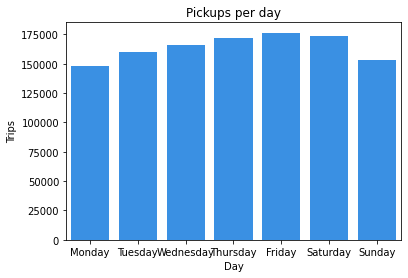

In [89]:
import seaborn as sns
ax = sns.countplot(df_train['pickup_day_name'], 
                   order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday' , 'Sunday'],
                   color = 'dodgerblue')
ax.set_title('Pickups per day')
ax.set_ylabel('Trips'), ax.set_xlabel('Day')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


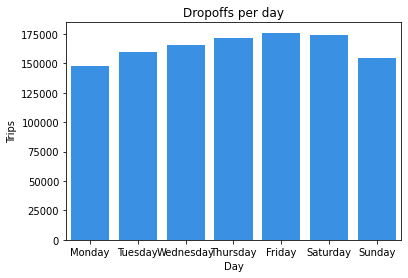

In [90]:
ax = sns.countplot(df_train['dropoff_day_name'], 
                   order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday' , 'Sunday'],
                   color = 'dodgerblue')
ax.set_title('Dropoffs per day')
ax.set_ylabel('Trips'), ax.set_xlabel('Day')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


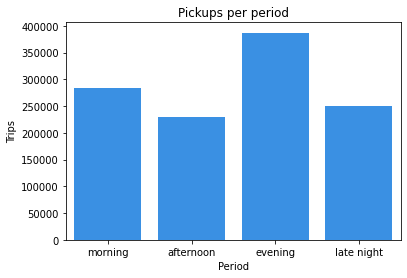

In [91]:
ax = sns.countplot(df_train['pickup_period'], 
                   order=['morning', 'afternoon', 'evening', 'late night'],
                   color = 'dodgerblue')
ax.set_title('Pickups per period')
ax.set_ylabel('Trips'), ax.set_xlabel('Period')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


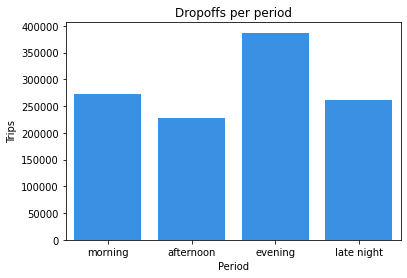

In [92]:
ax = sns.countplot(df_train['dropoff_period'], 
                   order=['morning', 'afternoon', 'evening', 'late night'],
                   color = 'dodgerblue')
ax.set_title('Dropoffs per period')
ax.set_ylabel('Trips'), ax.set_xlabel('Period')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


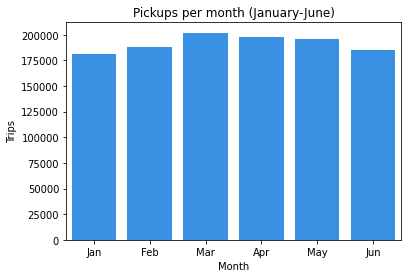

In [93]:
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
ax = sns.countplot(df_train['pickup_month'].map(month_dict), 
                   order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
                   color = 'dodgerblue')
ax.set_title('Pickups per month (January-June)')
ax.set_ylabel('Trips'), ax.set_xlabel('Month')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


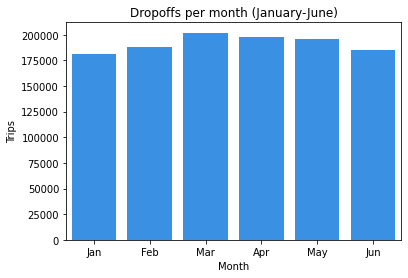

In [94]:
ax = sns.countplot(df_train['pickup_month'].map(month_dict), 
                   order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
                   color = 'dodgerblue')
ax.set_title('Dropoffs per month (January-June)')
ax.set_ylabel('Trips'), ax.set_xlabel('Month')
plt.show()

Calculate average trip duration per pickup hour/day_period/day of week

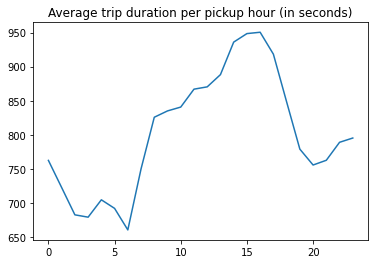

In [95]:
group_hour_df_train = df_train[['pickup_hour', 'trip_duration']]
group_hour_df_train = group_hour_df_train.groupby('pickup_hour')
mean_group_hour_df_train = group_hour_df_train.mean().reset_index()

plt.plot(mean_group_hour_df_train['pickup_hour'], mean_group_hour_df_train['trip_duration']), plt.title('Average trip duration per pickup hour (in seconds)')
plt.show()


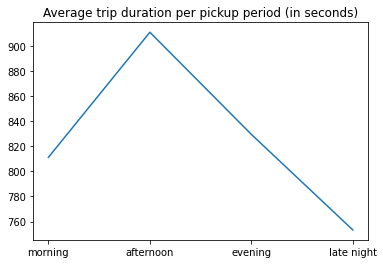

In [96]:
group_period_df_train = df_train[['pickup_period', 'trip_duration']]
group_period_df_train = group_period_df_train.groupby('pickup_period')
mean_group_period_df_train = group_period_df_train.mean().reset_index().reindex([3, 0, 1, 2])

plt.plot(mean_group_period_df_train['pickup_period'], mean_group_period_df_train['trip_duration']), plt.title('Average trip duration per pickup period (in seconds)')
plt.show()

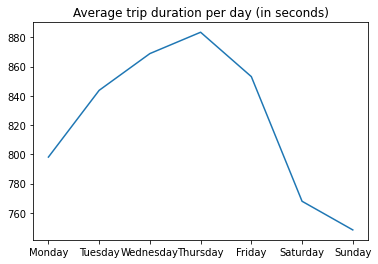

In [97]:
group_day_df_train = df_train[['pickup_day_name', 'trip_duration']]
group_day_df_train = group_day_df_train.groupby('pickup_day_name')
mean_group_day_df_train = group_day_df_train.mean().reset_index().reindex([1, 5, 6, 4, 0, 2, 3])

plt.plot(mean_group_day_df_train['pickup_day_name'], mean_group_day_df_train['trip_duration']), plt.title('Average trip duration per day (in seconds)')
plt.show()

Plot trip duration histogram, and then transform them to log and plot again

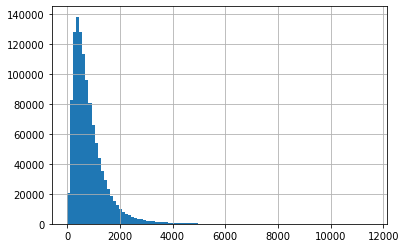

In [98]:
duration_hist = df_train['trip_duration'].hist(bins = 100)

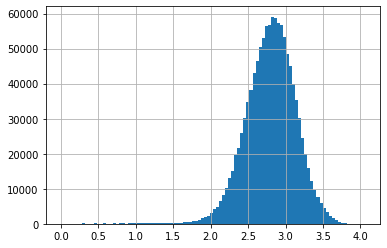

In [99]:
df_train['log_trip_duration'] = np.log10(df_train['trip_duration'])
log_duration_hist = df_train['log_trip_duration'].hist(bins = 100)

Group by vendor id and plot average trip duration

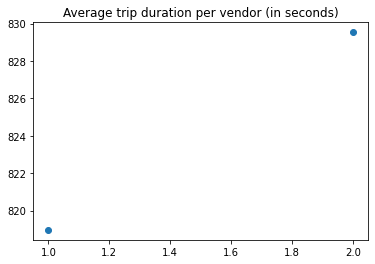

In [100]:
group_vendor_df_train = df_train[['vendor_id', 'trip_duration']]
group_vendor_df_train = group_vendor_df_train.groupby('vendor_id')
mean_group_vendor_df_train = group_vendor_df_train.mean().reset_index()

plt.scatter(mean_group_vendor_df_train['vendor_id'], mean_group_vendor_df_train['trip_duration']), plt.title('Average trip duration per vendor (in seconds)')
plt.show()

Group by passenger count and plot again

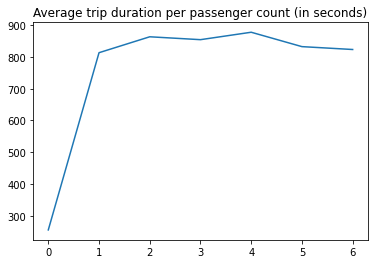

In [101]:
group_passenger_df_train = df_train[['passenger_count', 'trip_duration']]
group_passenger_df_train = group_passenger_df_train.groupby('passenger_count')
mean_group_passenger_df_train = group_passenger_df_train.mean().reset_index()

plt.plot(mean_group_passenger_df_train['passenger_count'], mean_group_passenger_df_train['trip_duration']), plt.title('Average trip duration per passenger count (in seconds)')
plt.show()

Calculate Manhattan distance between points and plot duration/distance and distance/day

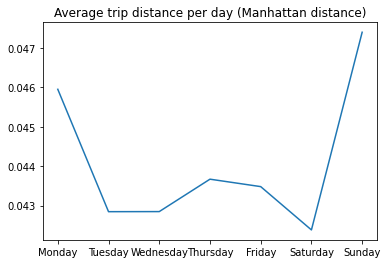

In [102]:
df_train['distance'] = abs(df_train['dropoff_latitude'] - df_train['pickup_latitude']) + abs(df_train['dropoff_longitude'] - df_train['pickup_longitude'])

group_day_df_train = df_train[['pickup_day_name', 'distance']]
group_day_df_train = group_day_df_train.groupby('pickup_day_name')
mean_group_day_df_train = group_day_df_train.mean().reset_index().reindex([1, 5, 6, 4, 0, 2, 3])

plt.plot(mean_group_day_df_train['pickup_day_name'], mean_group_day_df_train['distance']), plt.title('Average trip distance per day (Manhattan distance)')
plt.show()

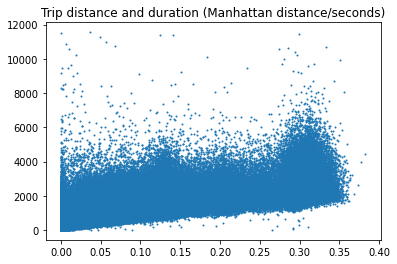

In [103]:
plt.scatter(df_train['distance'], df_train['trip_duration'], s=1), plt.title('Trip distance and duration (Manhattan distance/seconds)')
plt.show()

Calculate velocity, and group average velocity by hour/day/month

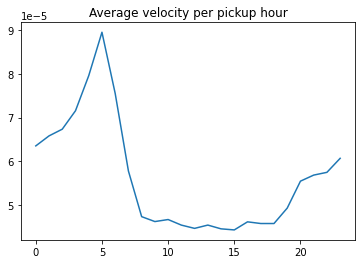

In [104]:
df_train['velocity'] = df_train['distance']/df_train['trip_duration']

group_hour_df_train = df_train[['pickup_hour', 'velocity']]
group_hour_df_train = group_hour_df_train.groupby('pickup_hour')
mean_group_hour_df_train = group_hour_df_train.mean().reset_index()

plt.plot(mean_group_hour_df_train['pickup_hour'], mean_group_hour_df_train['velocity']), plt.title('Average velocity per pickup hour')
plt.show()

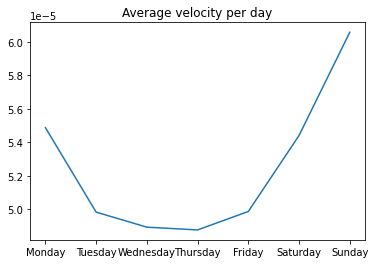

In [105]:
group_day_df_train = df_train[['pickup_day_name', 'velocity']]
group_day_df_train = group_day_df_train.groupby('pickup_day_name')
mean_group_day_df_train = group_day_df_train.mean().reset_index().reindex([1, 5, 6, 4, 0, 2, 3])

plt.plot(mean_group_day_df_train['pickup_day_name'], mean_group_day_df_train['velocity']), plt.title('Average velocity per day')
plt.show()

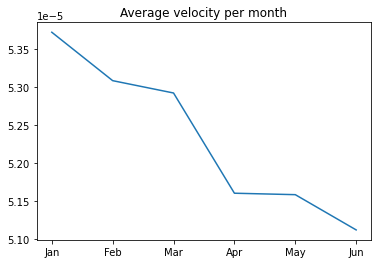

In [106]:
group_month_df_train = df_train[['pickup_month', 'velocity']]
group_month_df_train = group_month_df_train.groupby('pickup_month')
mean_group_month_df_train = group_month_df_train.mean().reset_index()

plt.plot(mean_group_month_df_train['pickup_month'].map(month_dict), mean_group_month_df_train['velocity']), plt.title('Average velocity per month')
plt.show()

Create scatter plots for latitude/longitude

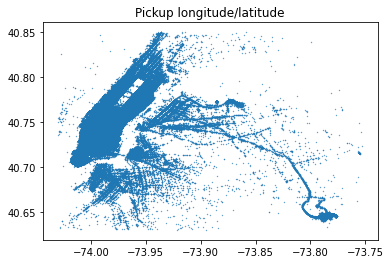

In [107]:
plt.scatter(df_train['pickup_longitude'], df_train['pickup_latitude'], s=0.1), plt.title('Pickup longitude/latitude')
plt.show()

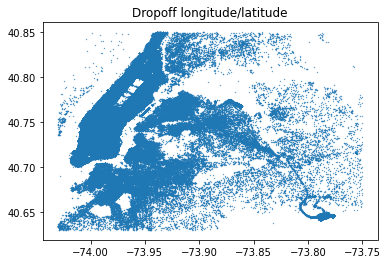

In [108]:
plt.scatter(df_train['dropoff_longitude'], df_train['dropoff_latitude'], s=0.1), plt.title('Dropoff longitude/latitude')
plt.show()

KMeans clustering with elbow method (pickup latitude/longitude)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

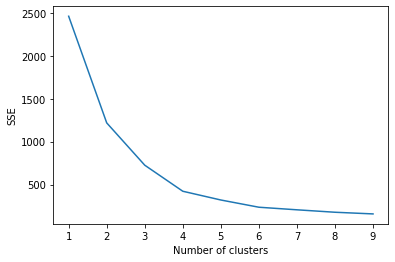

In [109]:
from sklearn.cluster import KMeans
X_train = df_train[['pickup_latitude', 'pickup_longitude']]
sse = {}

for k in range (1,10):
  kmeans = KMeans(n_clusters = k).fit(X_train)
  X_train['clusters'] = kmeans.labels_
  #print(data["clusters"])
  sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

As shown from plot above, optimal number is around 4-6 (diminishing returns), so we'll train KMeans again, and plot results along with centroids

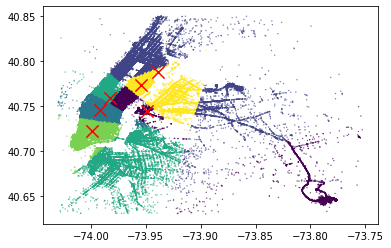

In [110]:
kmeans = KMeans(n_clusters = 6).fit(X_train)
centroids = kmeans.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
labels = kmeans.labels_

plt.scatter(X_train['pickup_longitude'], X_train['pickup_latitude'], c=labels, s=0.1)
plt.scatter(centroids_y, centroids_x, marker = "x", s = 150, c='red')
plt.show()

Perform regression using RandomForestRegressor. Also, transform string data to numeric.

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


X_train = df_train[['vendor_id', 'passenger_count', 'pickup_longitude', 
                    'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                    'pickup_day_name','pickup_month', 'pickup_season', 
                    'pickup_period','distance']][:10000]
y_train = df_train['log_trip_duration'][:10000]

df_test['distance'] = abs(df_test['dropoff_latitude'] - df_test['pickup_latitude']) + abs(df_test['dropoff_longitude'] - df_test['pickup_longitude'])
X_test = df_test[['vendor_id', 'passenger_count', 'pickup_longitude', 
                    'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                    'pickup_day_name','pickup_month', 'pickup_season', 
                    'pickup_period','distance']][:10000]

df_target['log_trip_duration'] = np.log10(df_target['trip_duration'])
y_test = df_target['log_trip_duration'][:10000]
for column in ['pickup_day_name', 'pickup_season', 'pickup_period']:
  X_train[column] = LabelEncoder().fit_transform(X_train[column])
  X_test[column] = LabelEncoder().fit_transform(X_test[column])

forest = RandomForestRegressor()
forest.fit(X_train, y_train)


RandomForestRegressor()

Compute feature importances (https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Elapsed time to compute the importances: 0.064 seconds


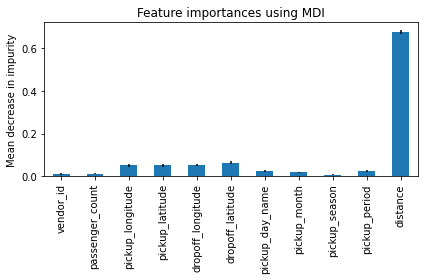

In [112]:
import time


start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
feature_names = list(X_train.columns)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The important features are longitude/latitude, and distance. We'll use them to retrain the model and apply grid search on max_depth, max_features, n_estimators

In [117]:
X_train = df_train[['pickup_longitude', 
                    'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                    'distance']][:10000]
y_train = df_train['log_trip_duration'][:10000]


X_test = df_test[['pickup_longitude', 
                    'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                    'distance']][:10000]

y_test = df_target['log_trip_duration'][:10000]

from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : (None, 2, 5), 
              'max_features' : (1.0, 'sqrt', 'log2'),
              'n_estimators' : (10, 100, 200)}
forest = RandomForestRegressor()
clf = GridSearchCV(forest, parameters)
clf.fit(X_train, y_train)
print('Best parameters: ', clf.best_params_)

Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


We'll predict on test set using the best parameters


In [120]:
predictions = clf.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Random Forest Regression Mean Absolute Error: ', mean_absolute_error(y_test, predictions))
print('Random Forest Regression Mean Squared Error: ', mean_squared_error(y_test, predictions))

Random Forest Regression Mean Absolute Error:  0.14632164143888668
Random Forest Regression Mean Squared Error:  0.0435680787743225


Visualize pickup point data using folium (https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython). Due to memory constraints, we'll use a sample of 1000 points. 

In [119]:
import folium

ny_map = folium.Map(prefer_canvas=True)
coords = [(lat, lon) for lat, lon in zip(df_train['pickup_latitude'][:1000],
                                            df_train['pickup_longitude'][:1000])]

for coord in coords:
  folium.Marker(location = [coord[0], coord[1]], icon=folium.Icon(color='red')).add_to(ny_map)

# Set the zoom to the maximum possible
ny_map.fit_bounds(ny_map.get_bounds())

# Save the map to an HTML file
ny_map.save('ny_map.html')
ny_map
